In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
import allan_variance
import pandas as pd
from calibration import IntrinsicCalibration
from scipy.spatial.transform import Rotation as R

/home/su/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

MagPIE Dataset

In [3]:
def interpolate_df(df_base, df_target, columns):
    df_interp = pd.DataFrame({'t': df_base['t']})
    for col in columns:
        df_interp[col] = np.interp(df_base['t'], df_target['t'], df_target[col])
    return df_interp

In [4]:
num_imus = 4

# IMU2_path = 'dataset/CSL/magpie2Dataset_1_imu2.csv'
# IMU3_path = 'dataset/CSL/magpie2Dataset_1_imu3.csv'
# IMU4_path = 'dataset/CSL/magpie2Dataset_1_imu4.csv'
# IMU5_path = 'dataset/CSL/magpie2Dataset_1_imu5.csv'
IMU2_path = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_path = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_path = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_path = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'

df2 = pd.read_csv(IMU2_path)
df3 = pd.read_csv(IMU3_path)
df4 = pd.read_csv(IMU4_path)
df5 = pd.read_csv(IMU5_path)

columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']
df3_interp = interpolate_df(df2, df3, columns)
df4_interp = interpolate_df(df2, df4, columns)
df5_interp = interpolate_df(df2, df5, columns)
dfs = [df2, df3_interp, df4_interp, df5_interp]
# dfs = [df1, df2, df3, df4, df5]

t_data = {}
gx_data, gy_data, gz_data = {}, {}, {}
ax_data, ay_data, az_data = {}, {}, {}
measurements = []

for i, df in enumerate(dfs, start=1):
    t_data[f'df{i}_t'] = np.array((df['t']-df['t'][0])/1e9)
    gx_data[f'df{i}_gx'] = np.array(df['gx'])
    gy_data[f'df{i}_gy'] = np.array(df['gy'])
    gz_data[f'df{i}_gz'] = np.array(df['gz'])
    ax_data[f'df{i}_ax'] = np.array(df['ax'])
    ay_data[f'df{i}_ay'] = np.array(df['ay'])
    az_data[f'df{i}_az'] = np.array(df['az'])

for i in range(len(df2)):
# for i in range(4000):
    # measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
    #                     ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
    #                     ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
    #                     ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i],
    #                     ax_data['df5_ax'][i], ay_data['df5_ay'][i], az_data['df5_az'][i], gx_data['df5_gx'][i], gy_data['df5_gy'][i], gz_data['df5_gz'][i]])
    measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
                        ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
                        ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
                        ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i]])
    
    
measurements = np.array(measurements)

dt = np.mean(np.diff(t_data['df1_t']))

The parameters of individiual sensors that are estimated from calibration

In [5]:
def calibrated_measurements(meas, det_params, biases): 
    gravity = 9.81
    cal_meas = []
    for i in range(len(meas)):
        all_meas = []
        for j in range(num_imus):
            raw_a = meas[i][j*6:j*6+3]
            raw_g = meas[i][j*6+3:j*6+6]
            b_a = [biases['ax'][f'df{j+2}_ax'], biases['ay'][f'df{j+2}_ay'], biases['az'][f'df{j+2}_az']]
            b_g = [biases['gx'][f'df{j+2}_gx'], biases['gy'][f'df{j+2}_gy'], biases['gz'][f'df{j+2}_gz']]
            SM_a = np.linalg.inv(det_params['acc_M'][f'imu{j+2}'])
            SM_g = np.linalg.inv(det_params['acc_M'][f'imu{j+2}'])
            A = det_params['A'][f'imu{j+2}']
            a_si = raw_a - b_a
            a_si[2] -= gravity
            a_si = np.dot(SM_a, a_si)
            g_si = np.dot(SM_g, (raw_g - b_g - np.dot(A, a_si)))

            new_meas = np.array([a_si, g_si]).flatten()
            all_meas.append(new_meas)
        flattened_meas = np.array(all_meas).flatten()
        cal_meas.append(flattened_meas)
    
    return cal_meas

IMU1_cal = 'dataset/static/magpie2Dataset_StaticData_imu1.csv'
IMU2_cal = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_cal = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_cal = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_cal = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'
IMU_paths = [IMU1_cal, IMU2_cal, IMU3_cal, IMU4_cal, IMU5_cal]
cal_path = 'dataset/static/magpie2Dataset_000-imu.yaml'
cal = IntrinsicCalibration(IMU_paths, cal_path)
cal.get_av_params()
cal.get_bias()
cal.get_det_params()
params = cal.params
biases = cal.biases
det_params = cal.det_params


T01 = np.array(det_params['T_i_b']['imu1'])
T02 = np.array(det_params['T_i_b']['imu2'])
T03 = np.array(det_params['T_i_b']['imu3'])
T04 = np.array(det_params['T_i_b']['imu4'])
T05 = np.array(det_params['T_i_b']['imu5'])

R21 = T02[:3,:3].T.dot(T01[:3,:3])
R31 = T03[:3,:3].T.dot(T01[:3,:3])
R41 = T04[:3,:3].T.dot(T01[:3,:3])
R51 = T05[:3,:3].T.dot(T01[:3,:3])
R_acc = [np.eye(3), R21.T, R31.T, R41.T, R51.T]

P21 = -T02[:3,3] + T01[:3,3]
P31 = -T03[:3,3] + T01[:3,3]
P41 = -T04[:3,3] + T01[:3,3]
P51 = -T05[:3,3] + T01[:3,3]

C01 = np.array(det_params['C_gyro_i']['imu1'])
C02 = np.array(det_params['C_gyro_i']['imu2'])
C03 = np.array(det_params['C_gyro_i']['imu3'])
C04 = np.array(det_params['C_gyro_i']['imu4'])
C05 = np.array(det_params['C_gyro_i']['imu5'])

C21 = C02.T.dot(C01)
C31 = C03.T.dot(C01)
C41 = C04.T.dot(C01)
C51 = C05.T.dot(C01)
R_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]


cal_meas = calibrated_measurements(measurements, det_params, biases)
cal_meas = np.array(cal_meas)

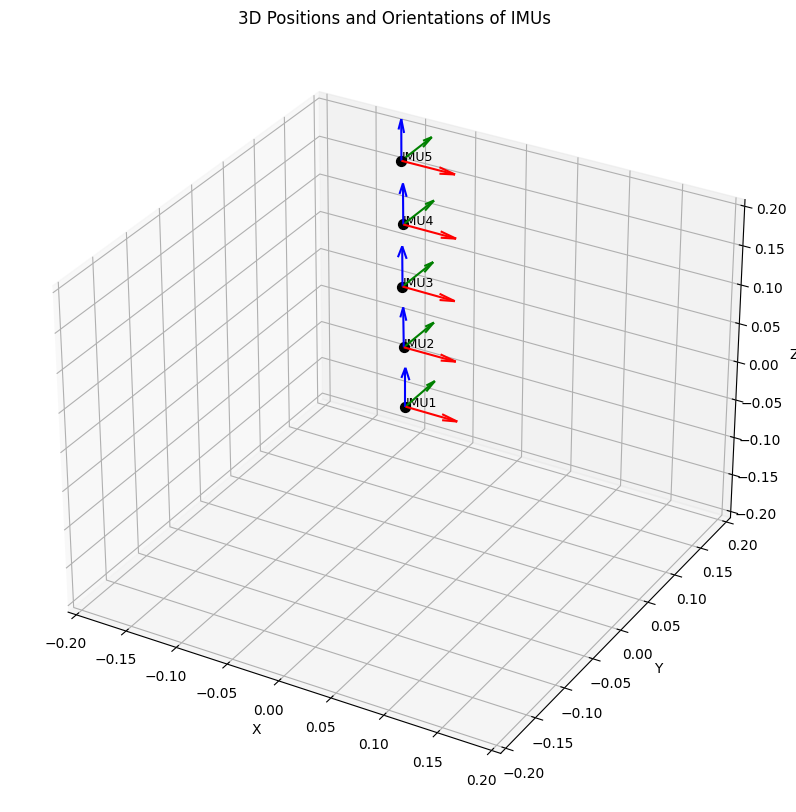

In [6]:
positions = [np.array([0, 0, 0]), -P21, -P31, -P41, -P51]

rotations = [np.eye(3), R21.T, R31.T, R41.T, R51.T]
rotations_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
axis_colors = ['r', 'g', 'b']
labels = ['IMU1', 'IMU2', 'IMU3', 'IMU4', 'IMU5']

for i, (pos, rot) in enumerate(zip(positions, rotations_gyro)):
    ax.scatter(pos[0], pos[1], pos[2], color='k', s=50)
    ax.text(pos[0], pos[1], pos[2], labels[i], fontsize=9)
    for j in range(3):
        axis = rot[:, j]
        ax.quiver(pos[0], pos[1], pos[2], axis[0], axis[1], axis[2], length=0.05, color=axis_colors[j])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)
ax.set_title('3D Positions and Orientations of IMUs')

plt.show()

In [7]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def measurement_est(meas_raw, pos_r, Rb_si, num_imus):
    state = np.zeros(9*num_imus)
    H = np.zeros((6*num_imus, 9))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = meas_raw[0:3]
        omega = meas_raw[3:6]
        H_i = np.zeros((6, 9))
        A = wedge(omega) @ wedge(r_sub) + wedge(wedge(omega) @ r_sub)
        H_i[0:3, 0:3] = - Rb_si_sub @ A
        H_i[0:3, 3:6] = - Rb_si_sub @ wedge(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[3:6, 0:3] = Rb_si_sub
        state_i = np.linalg.pinv(H_i.T @ H_i) @ H_i.T @ meas_raw[i*6:6+i*6]
        state[i*9:9+i*9] = state_i
    
    return state

In [8]:
w_input_noise = 1e-3

Rb_si = [R21.T, R31.T, R41.T, R51.T]
pos_r = [-P21, -P31, -P41, -P51]
time = t_data['df1_t']

meas = np.zeros(6*num_imus)
state_est_hist = np.zeros((len(time),9*num_imus))

for i in trange(len(time)):
    meas = measurement_est(cal_meas[i], pos_r, Rb_si, num_imus)
    state_est_hist[i] = meas

100%|██████████| 375162/375162 [02:56<00:00, 2122.21it/s]


Text(0.5, 0, 'Time (s)')

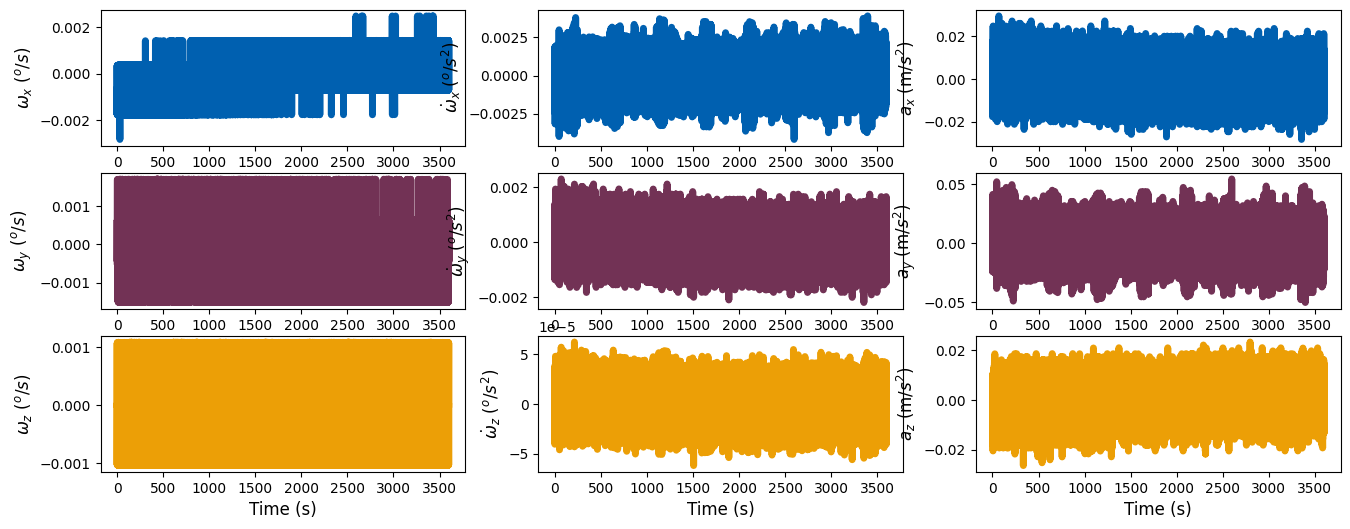

In [9]:
fig2, ax2 = plt.subplots(3, 3, figsize = (16, 6))
ax2[0,0].plot(time, state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "${\omega}_x$")
ax2[1,0].plot(time, state_est_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_y$")
ax2[2,0].plot(time, state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "${\omega}_z$")
ax2[0,0].set_ylabel("${\omega}_x$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("${\omega}_y$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("${\omega}_z$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "${\dot{\omega}}_x$")
ax2[1,1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "${\dot{\omega}}_y$")
ax2[2,1].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "${\dot{\omega}}_z$")
ax2[0,1].set_ylabel("${\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("${\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("${\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

ax2[0,2].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$a_x$")
ax2[1,2].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$a_y$")
ax2[2,2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$a_z$")
ax2[0,2].set_ylabel("${a}_x$ (m/$s^2$)", fontsize=12)
ax2[1,2].set_ylabel("${a}_y$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_ylabel("${a}_z$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

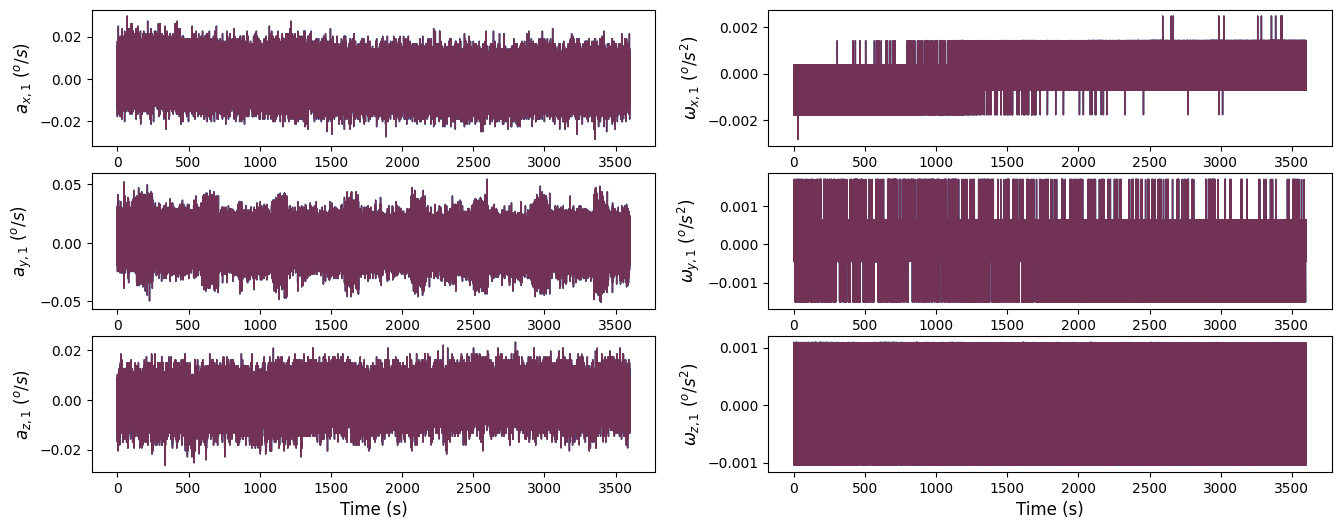

In [10]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, cal_meas[:,0],       linewidth=1, color = "#0060B0", label = "$a_{x,1}$")
ax2[0,0].plot(time, state_est_hist[:,6], linewidth=1, color = "#723255", label = "$\hat{a}_x$")
ax2[1,0].plot(time, cal_meas[:,1],       linewidth=1, color = "#0060B0", label = "$a_{y,1}$")
ax2[1,0].plot(time, state_est_hist[:,7], linewidth=1, color = "#723255", label = "$\hat{a}_y$")
ax2[2,0].plot(time, cal_meas[:,2],       linewidth=1, color = "#0060B0", label = "$a_{z,1}$")
ax2[2,0].plot(time, state_est_hist[:,8], linewidth=1, color = "#723255", label = "$\hat{a}_z$")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, cal_meas[:,3],       linewidth=1, color = "#0060B0", label = "$\omega_{x,1}$")
ax2[0,1].plot(time, state_est_hist[:,0], linewidth=1, color = "#723255", label = "$\hat{\omega}_x$")
ax2[1,1].plot(time, cal_meas[:,4],       linewidth=1, color = "#0060B0", label = "$\omega_{y,1}$")
ax2[1,1].plot(time, state_est_hist[:,1], linewidth=1, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,1].plot(time, cal_meas[:,5],       linewidth=1, color = "#0060B0", label = "$\omega_{z,1}$")
ax2[2,1].plot(time, state_est_hist[:,2], linewidth=1, color = "#723255", label = "$\hat{\omega}_z$")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

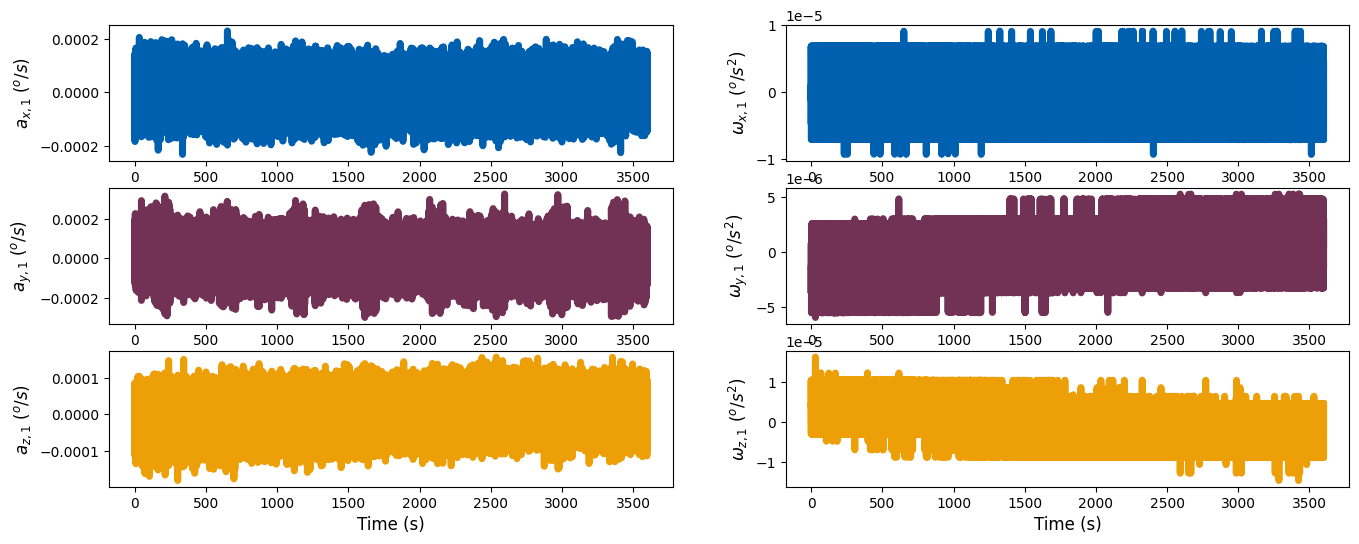

In [11]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, cal_meas[:,0]-state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, cal_meas[:,1]-state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, cal_meas[:,2]-state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, cal_meas[:,3]-state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, cal_meas[:,4]-state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, cal_meas[:,5]-state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Inertial Navigation

In [12]:
class InertialNavigation:
    def __init__(self, dt):
        self.dt = dt
        self.position = np.zeros(3)
        self.velocity = np.zeros(3)
        self.angle = np.zeros(3)
        self.orientation = np.array([1, 0, 0, 0])  # Initial quaternion (w, x, y, z)
        self.pos_hist = []
        self.ori_hist = []
        self.ang_hist = []
        self.vel_hist = []
    
    def update(self, angular_velocity, acceleration):
        self.orientation = self._update_orientation(self.orientation, angular_velocity)
        accel_world = self._rotate_vector(acceleration, self.orientation)
        self.velocity += accel_world * self.dt
        self.position += self.velocity * self.dt
        self.angle = self.quaternion_to_euler(self.orientation)
        self.pos_hist.append(self.position.copy())
        self.ori_hist.append(self.orientation.copy())
        self.ang_hist.append(self.angle.copy())
        self.vel_hist.append(self.velocity.copy())
    
    def _update_orientation(self, quat, angular_velocity):
        wx, wy, wz = self.DEG2RAD(angular_velocity)
        omega = np.array([0, wx, wy, wz]) * 0.5 * self.dt
        dq = self._quaternion_multiply(quat, omega)
        quat_new = quat + dq
        return quat_new / np.linalg.norm(quat_new)  # Normalize to maintain unit quaternion
    
    def _quaternion_multiply(self, q, r):
        w1, x1, y1, z1 = q
        w2, x2, y2, z2 = r
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])
    
    def _rotate_vector(self, vec, quat):
        q_vec = np.array([0, *vec])
        q_conj = np.array([quat[0], -quat[1], -quat[2], -quat[3]])
        rotated_vec = self._quaternion_multiply(self._quaternion_multiply(quat, q_vec), q_conj)
        return rotated_vec[1:]
    
    def get_position_and_orientation(self):
        return self.position, self.orientation

    def DEG2RAD(self, deg):
        return deg * (math.pi / 180)
    
    def quaternion_to_euler(self, q, degrees=True):
        rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # Scipy expects [x, y, z, w] format
        euler_angles = rotation.as_euler('xyz', degrees=degrees)
        return euler_angles

angular_velocity_data = state_est_hist[:,0:3]
acceleration_data = state_est_hist[:,6:9]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_est_hist = np.array(ins.pos_hist)
ang_est_hist = np.array(ins.ang_hist)
vel_est_hist = np.array(ins.vel_hist)

Text(0, 0.5, '$\\hat{r}$ ($m$)')

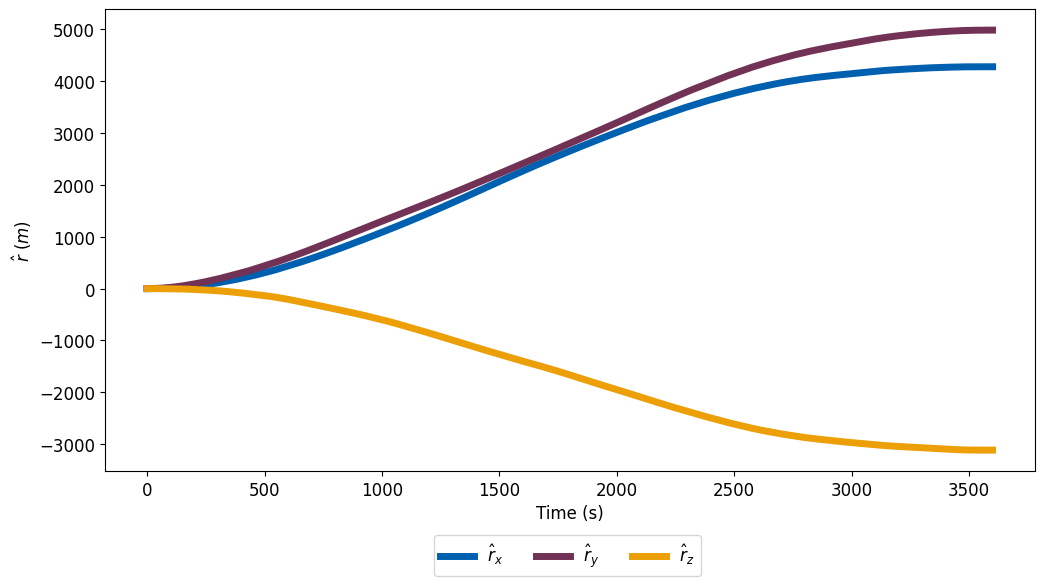

In [13]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], pos_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], pos_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], pos_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{r}$ ($m$)", fontsize=12)

In [14]:
angular_velocity_data = cal_meas[:,3:6]
acceleration_data = cal_meas[:,0:3]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_raw_hist = np.array(ins.pos_hist)
ang_raw_hist = np.array(ins.ang_hist)
vel_raw_hist = np.array(ins.vel_hist)

Text(0.5, 0, 'Time (s)')

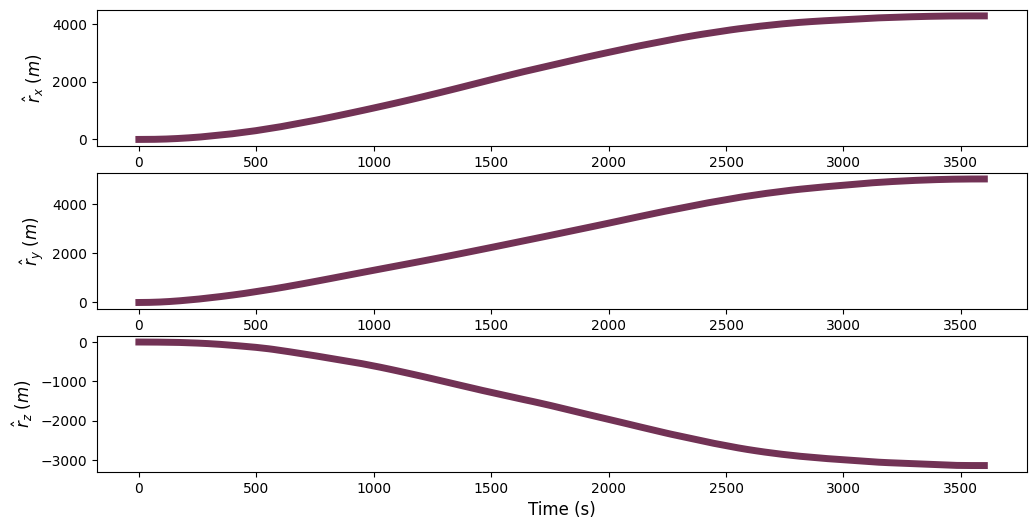

In [15]:
fig2, ax2 = plt.subplots(3, 1, figsize = (12, 6))
ax2[0].plot(time, pos_raw_hist[:,0], linewidth=5, color = "#723255", label = "${\omega}_{x,1}$")
ax2[1].plot(time, pos_raw_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_{y,1}$")
ax2[2].plot(time, pos_raw_hist[:,2], linewidth=5, color = "#723255", label = "${\omega}_{z,1}$")
ax2[0].set_ylabel("$\hat{r}_x$ ($m$)", fontsize=12)
ax2[1].set_ylabel("$\hat{r}_y$ ($m$)", fontsize=12)
ax2[2].set_ylabel("$\hat{r}_z$ ($m$)", fontsize=12)
ax2[2].set_xlabel("Time (s)", fontsize=12)


Text(0, 0.5, '$\\hat{\\Theta}$ ($deg/s$)')

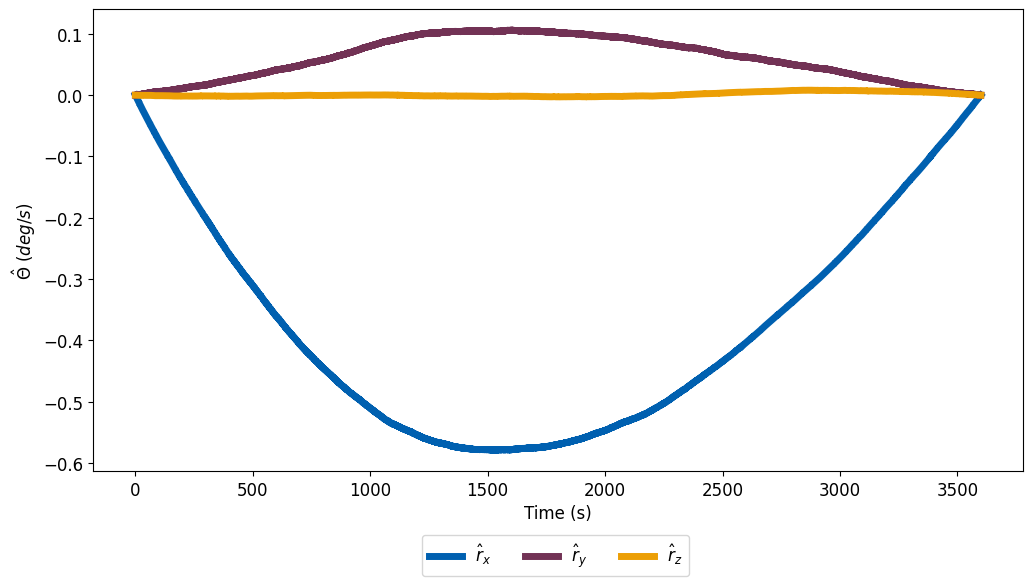

In [28]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], ang_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], ang_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], ang_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\Theta}$ ($deg/s$)", fontsize=12)

DISIMU omega hat: quantization    0.00000000000000
white           0.00005109914525
flicker         0.00001226670081
walk            0.00000195544759
ramp            0.00000035172268
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00006122858168
flicker         0.00001515020511
walk            0.00000000000000
ramp            0.00000008127977
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00002901627482
flicker         0.00000369122829
walk            0.00000023974063
ramp            0.00000001609092
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

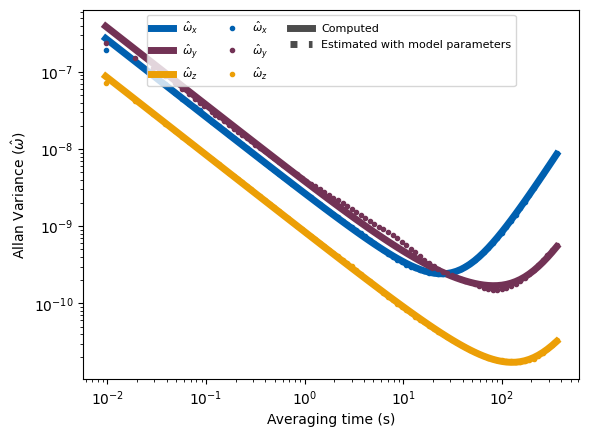

In [17]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wy, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wz, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.00000000000000
white           0.00005111316523
flicker         0.00001225892487
walk            0.00000195617644
ramp            0.00000035181627
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00006121826326
flicker         0.00001515166454
walk            0.00000000000000
ramp            0.00000008083391
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00002900718885
flicker         0.00000373042049
walk            0.00000022342608
ramp            0.00000001667405
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00000000000000
white           0.00004942323683
flicker         0.00001753421278
walk            0.00000000000000
ramp            0.00000085942049
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00005307969494
flicker         0.00001080244361
walk            0.00000000000000
ramp            0.00000019605496
Name: 0, dtype: float64, quantization    0.00000

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

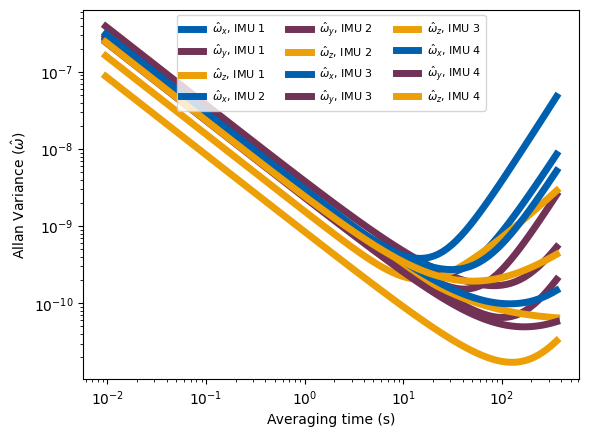

In [18]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(cal_meas[:,j*6+3], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(cal_meas[:,j*6+4], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(cal_meas[:,j*6+5], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([1e-8, 1])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

DISIMU SF hat: quantization    0.00000000000000
white           0.00056785231493
flicker         0.00035084551930
walk            0.00003128148332
ramp            0.00000085960500
Name: 0, dtype: float64, quantization    0.00003075154566
white           0.00069623050932
flicker         0.00033464606449
walk            0.00004983646240
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00050185500862
flicker         0.00096004373595
walk            0.00000000000000
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

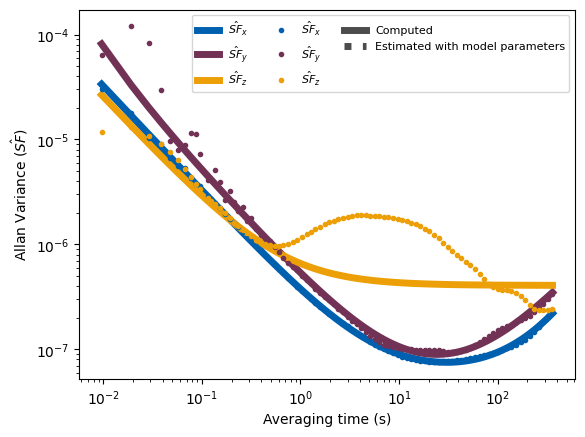

In [19]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.00000000000000
white           0.00057102163796
flicker         0.00035072735400
walk            0.00003138256373
ramp            0.00000085322723
Name: 0, dtype: float64, quantization    0.00003094694878
white           0.00070033621666
flicker         0.00033607344132
walk            0.00005021720863
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00050167624394
flicker         0.00096264039898
walk            0.00000000000000
ramp            0.00000000000000
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.00000000000000
white           0.00055623287256
flicker         0.00037517526131
walk            0.00003468057523
ramp            0.00000102698583
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00061344311119
flicker         0.00032170287369
walk            0.00006132158147
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.000

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

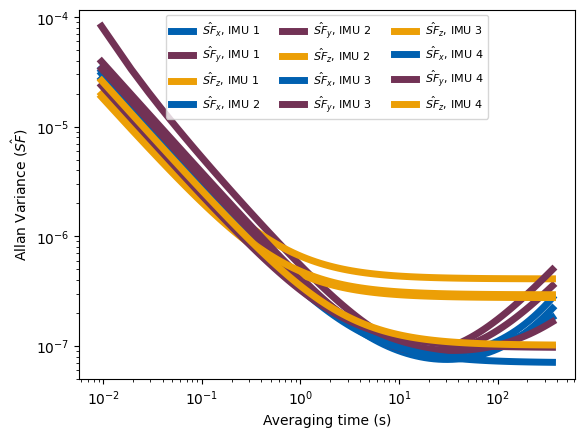

In [20]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(cal_meas[:,j*6], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(cal_meas[:,j*6+1], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(cal_meas[:,j*6+2], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0.5, 0, 'Time (s)')

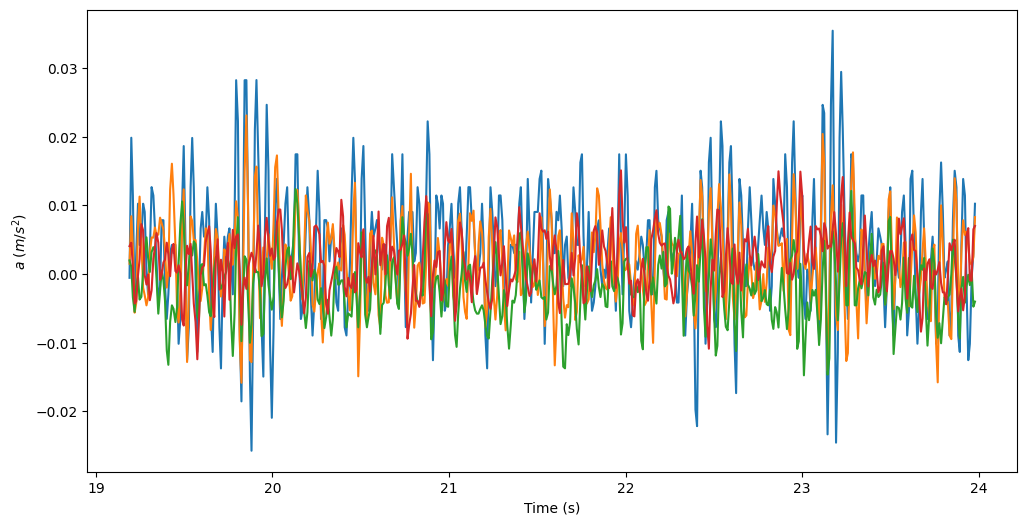

In [21]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    # plt.plot(time[2000:2500], cal_meas[2000:2500,j*6])
    plt.plot(time[2000:2500], cal_meas[2000:2500,j*6+1])
    # plt.plot(time[2000:2500], cal_meas[2000:2500,j*6+2])
plt.ylabel("$a$ ($m/s^2$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

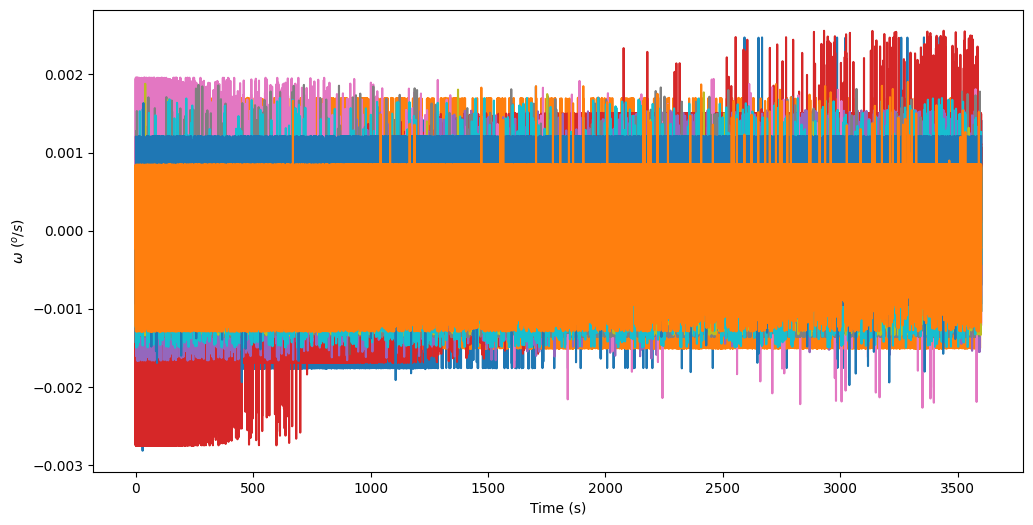

In [22]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, cal_meas[:,j*6+3])
    plt.plot(time, cal_meas[:,j*6+4])
    plt.plot(time, cal_meas[:,j*6+5])
plt.ylabel("$\omega$ ($^{o}/s$)")
plt.xlabel("Time (s)")

Ground truth from google tango

In [23]:
for j in range(1, 2):
    print(j)

1


In [24]:
t_data = {}
gx_data, gy_data, gz_data = {}, {}, {}
ax_data, ay_data, az_data = {}, {}, {}
measurements = []

for i, df in enumerate(dfs, start=1):
    t_data[f'df{i}_t'] = np.array((df['t']-df['t'][0])/1e9)
    gx_data[f'df{i}_gx'] = np.array(df['gx'])
    gy_data[f'df{i}_gy'] = np.array(df['gy'])
    gz_data[f'df{i}_gz'] = np.array(df['gz'])
    ax_data[f'df{i}_ax'] = np.array(df['ax'])
    ay_data[f'df{i}_ay'] = np.array(df['ay'])
    az_data[f'df{i}_az'] = np.array(df['az'])

In [25]:
num_traj = 4

t_hist = {}
P_TA_hist = {}
R_TA_hist = {}

for j in range(1, num_traj+1):
    start = f'dataset/CSL/magpie2Dataset_{j}_tango_start.csv'
    area  = f'dataset/CSL/magpie2Dataset_{j}_tango_area.csv'

    dfs = pd.read_csv(start)
    dfa = pd.read_csv(area)

    ts  = np.array((dfs['t'] - dfs['t'][0])*10e-9)
    pxs = np.array(dfs['px'])
    pys = np.array(dfs['py'])
    pzs = np.array(dfs['pz'])
    rxs = np.array(dfs['rx'])
    rys = np.array(dfs['ry'])
    rzs = np.array(dfs['rz'])
    rws = np.array(dfs['rw'])

    pxa = dfa['px'][0]
    pya = dfa['py'][0]
    pza = dfa['pz'][0]
    rxa = dfa['rx'][0]
    rya = dfa['ry'][0]
    rza = dfa['rz'][0]
    rwa = dfa['rw'][0]
    q_SA = [rxa, rya, rza, rwa]
    R_SA = R.from_quat(q_SA)
    P_SA = [pxa, pya, pza]

    p_hist = []
    r_hist = []

    for i in range(len(dfs)):
        q_TS = [rxs[i], rys[i], rzs[i], rws[i]]
        R_TS = R.from_quat(q_TS)
        R_TA = R_TS * R_SA

        P_TS = np.array([pxs[i], pys[i], pzs[i]])
        P_TA = P_TS + R_TS.apply(P_SA)
        p_hist.append(P_TA)

        angles = R_TA.as_euler('xyz', degrees=True)
        r_hist.append(angles)

    P_TA_hist[f'traj_{j}'] = np.array(p_hist)
    R_TA_hist[f'traj_{j}'] = np.array(r_hist)

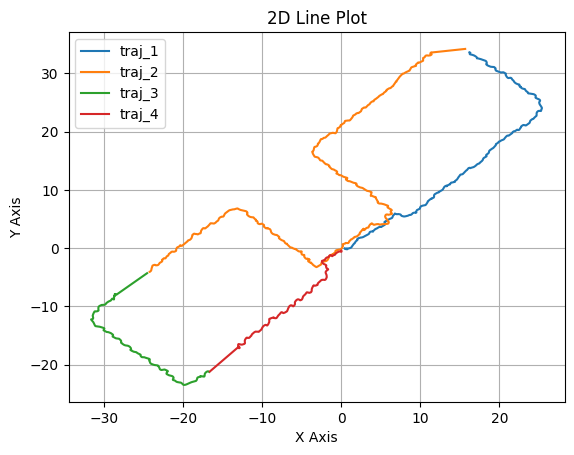

In [26]:
for j in range(1, num_traj+1):
    plt.plot(P_TA_hist[f'traj_{j}'][:,0], P_TA_hist[f'traj_{j}'][:,1], label=f'traj_{j}')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('2D Line Plot')
plt.legend()
plt.grid(True)
plt.show()